# Customer Demand Variation

## 0. Small introduction and contextualization to the model

One of the most significant challenges that a production or logistic planner can face nowadays is the lack of confidence in the volume prediction data it is received from the clients. 

Week after week, these volume forecasts that are first informed can change abruptly. By the time they are confirmed by the clients, the numbers are often very different from the initial received ones, and usually happens that the first informed figures were already used to plan internal resources and cascade material planning to the suppliers.

To mitigate this negative impact, many production planners apply a correction factor (usually a reduction factor) for each client or for specific products and part numbers. However, the knowledge and expertise required to determine these appropriate correction factors is heavily dependent on the experience and personal knowledge of the production or logistics planner. This reliance obviously presents limitations, as the process is entirely manual and lacks a systematic approach.

This brings us to the idea behind developing a predictive model: could we create a system that estimates the optimal correction factor based on historical data? Such a model would provide production and logistics planners across the industry with a consistent and data-driven method to apply the most accurate correction factors, ultimately optimizing supplier material plans, production schedules, and resource allocation.

The potential benefits include:
- A more accurate raw material supply plan, reducing the risk of component shortages and the need for urgent freight shipments.
- Avoiding over-ordering of raw materials, which can lead to excess inventory in the warehouse and unnecessary expenses.
- Improved production planning, minimizing the need for last-minute schedule changes.
- More precise resource planning, enabling the quick identification of potential underloads or overloads in production capacity.

## 1. Load the required libraries and the dataset

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [11]:
#install -c conda-forge openpyxl>=3.1.0
#!conda install xgboost

In [12]:
import openpyxl
print(openpyxl.__version__)

3.1.5


In [13]:
#The data set is already partially prepared and saved in an Excel's file
demand_variation = pd.read_excel('Portfolio_Customer_Demand_Variation.xlsx', sheet_name='Final')

In [14]:
#Let's check and understand its format
demand_variation.head()

,Part number,Type,Client,First Preview Week,Production Week (W0),Month,Holliday,Module cost,Registered Vehicles Variation (M-1),Interest rate (M-1),Inflation (M-1),Initial previewed volume,Confirmed volume,Leadtime preview,Volume's cut (Percentage remainder)
0,C,A,A,12,27,7,False,17.25,124806,4.5,1.3,4770,1620,15,0.339623
1,C,A,A,12,28,7,False,17.25,124806,4.5,1.3,4770,2070,16,0.433962
2,C,A,A,12,29,7,False,17.25,124806,4.5,1.3,4860,2880,17,0.592593
3,C,A,A,12,30,7,False,17.25,124806,4.5,1.3,4770,2700,18,0.566038
4,C,A,A,12,31,7,False,17.25,124806,4.5,1.3,3960,2790,19,0.704545


Explaining the dataset's columns:

- **Part number**: identification number of the final product (Source: randomly generated data for the purpose of the pilot model development)
- **Type**: construction type of the final product (Source: randomly generated data for the purpose of the pilot model development)
- **Client**: client to which the final product is delivered (Source: randomly generated data for the purpose of the pilot model development)
- **First preview week**: week on which the first production's volume (already an estimation) is informed (Source: randomly generated data for the purpose of the pilot model development)
- **Production week**: To which week is previewed the deliver of that informed production's volume (Source: randomly generated data for the purpose of the pilot model development)
- **Holiday**: signs if in the delivery week there is any holiday (Source: randomly generated data for the purpose of the pilot model development)
- **Module cost**: manufacturing cost, related to each part number (Source: randomly generated data for the purpose of the pilot model development)
- **Registered Vehicles Variation (M-1)**: number of registered vehicles (in Italy, place where the author is based nowadays) in the previous month regarding the delivery month (Source: Federauto)
- **Interest rate (M-1)**: inflation rate in Italy in the previous month regarding the delivery month (Source: ECB)
- **Inflation (M-1)**: inflation rate in Europe in the previous month regarding the delivery month (Source: Trading Economics)
- **Initial previewed volume**: first production volume informed by the client (Source: randomly generated data for the purpose of the pilot model development) 
- **Confirmed volume**: final confirmed volume by the client (usually one or two weeks before the delivery week) (Source: randomly generated data for the purpose of the pilot model development)
- **Lead time preview**: for how long is the production volume been reviewed and changed from the first communication until the final communication 
- **Volume's cut (Percentage remainder)**: percentage of confirmed volume in regards to the first informed volumes 

## 2. Perform exploratory data analysis (EDA)

In [15]:
#Let's first check if there is any missing value in the data set
demand_variation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Part number                          1092 non-null   object 
 1   Type                                 1092 non-null   object 
 2   Client                               1092 non-null   object 
 3   First Preview Week                   1092 non-null   int64  
 4   Production Week (W0)                 1092 non-null   int64  
 5   Month                                1092 non-null   int64  
 6   Holliday                             1092 non-null   bool   
 7   Module cost                          1092 non-null   float64
 8   Registered Vehicles Variation (M-1)  1092 non-null   int64  
 9   Interest rate (M-1)                  1092 non-null   float64
 10  Inflation (M-1)                      1092 non-null   float64
 11  Initial previewed volume      

In [16]:
#The only column with missing values is the "Volume's cut (Percentage remainder)", which by the way will be chosen as our target variable
#For the data to have more consistence, let's begin removing the rows with NA values
demand_variation = demand_variation.dropna()

In [17]:
#Now to go in the exploratory data analysis let's check all the values in the data set, starting with the categorical columns
for i in range(demand_variation.columns.shape[0]):
    if demand_variation.iloc[:,i].dtypes == 'object':
        print(demand_variation.columns[i])
        print(demand_variation.iloc[:,i].unique())
        print("-"*20)

print(demand_variation.columns[6])
print(demand_variation.iloc[:,6].unique())

Part number
['C' 'D' 'Q' 'P' 'A' 'B' 'F' 'G' 'L' 'M' 'S' 'R' 'T' 'U' 'E' 'N' 'O' 'J'
 'K' 'H' 'I']
--------------------
Type
['A' 'B' 'C']
--------------------
Client
['A' 'D' 'C' 'B' 'E']
--------------------
Holliday
[False  True]


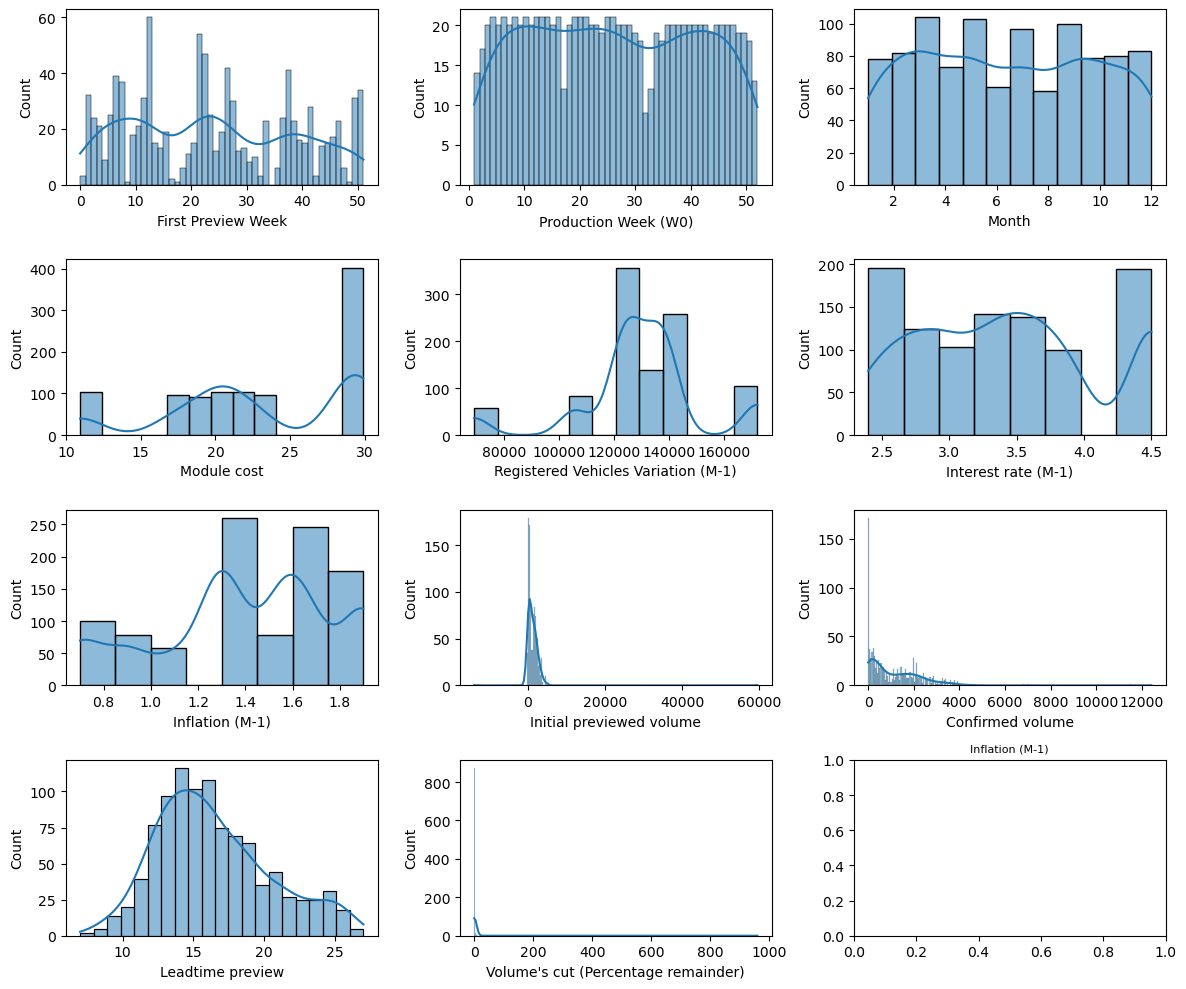

In [18]:
#And now let's have a look in the numerical columns
fig, axes = plt.subplots(4, 3, figsize=(12, 10))
axes = axes.flatten()

numeric_cols = demand_variation.select_dtypes(include='number')

for i, col in enumerate(numeric_cols):
    sns.histplot(demand_variation[col], ax=axes[i], bins=len(demand_variation[col].unique()), kde=True)
    plt.title(demand_variation.columns[i], fontsize=8)

plt.tight_layout()
plt.show()


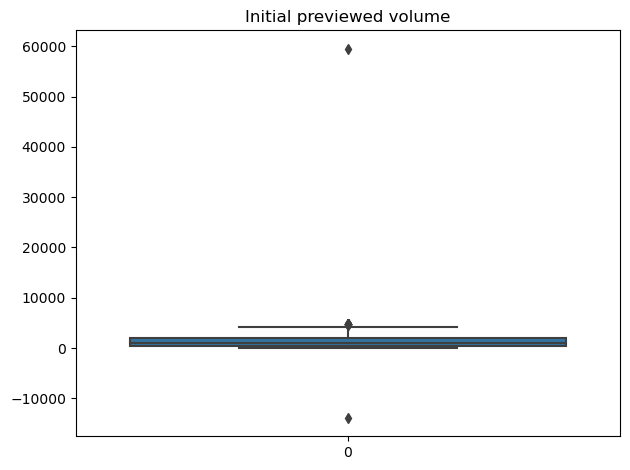

count      998.000000
mean      1333.729459
std       2171.794746
min     -13863.000000
25%        392.000000
50%        958.500000
75%       1980.000000
max      59503.000000
Name: Initial previewed volume, dtype: float64


In [19]:
#Some of the histograms are not optimally readable, let's explore them in details, starting the "Initial previewed volume"

sns.boxplot(demand_variation['Initial previewed volume'])
plt.title(label='Initial previewed volume', fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation['Initial previewed volume'].describe())

In [20]:
#From the above box plot, we can see that there are very extreme values as max and mix values that will very likely influence prediction accuracy of the model. 
#Let's find where they are as indexes and remove them from the data set

max_index = demand_variation['Initial previewed volume'].idxmax()
print('Index of maximal value: ',max_index)
min_index = demand_variation['Initial previewed volume'].idxmin()
print('Index of minimal value: ',min_index)

Index of maximal value:  755
Index of minimal value:  756


In [21]:
#Let's then now remove them from the dataset
demand_variation = demand_variation.drop([min_index,max_index])

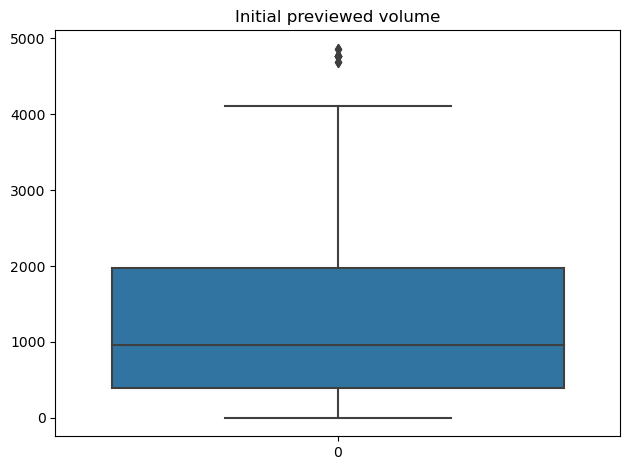

count     996.000000
mean     1290.584337
std      1044.768574
min         1.000000
25%       392.000000
50%       958.500000
75%      1980.000000
max      4860.000000
Name: Initial previewed volume, dtype: float64


In [22]:
#Let's check if the changes have worked

sns.boxplot(demand_variation['Initial previewed volume'])
plt.title(label='Initial previewed volume', fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation['Initial previewed volume'].describe())

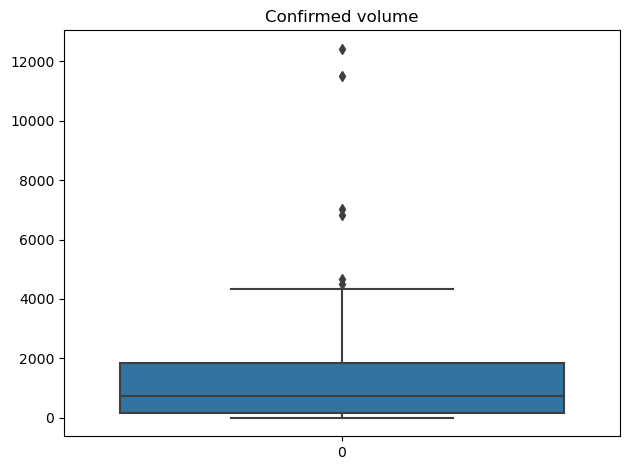

count      996.000000
mean      1107.202811
std       1174.890889
min          0.000000
25%        168.000000
50%        720.000000
75%       1848.000000
max      12420.000000
Name: Confirmed volume, dtype: float64


In [23]:
#Now let's explore the variable "Confirmed volume"

sns.boxplot(demand_variation['Confirmed volume'])
plt.title(label='Confirmed volume', fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation['Confirmed volume'].describe())

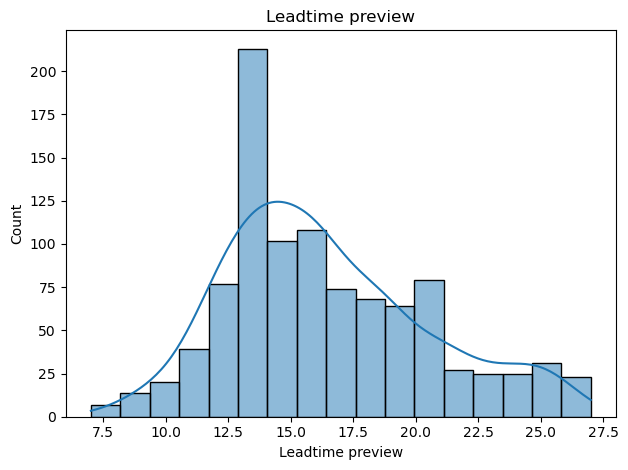

count    996.000000
mean      16.410643
std        4.092038
min        7.000000
25%       13.000000
50%       16.000000
75%       19.000000
max       27.000000
Name: Leadtime preview, dtype: float64


In [24]:
#Now let's explore the variable "Lead time preview"

sns.histplot(demand_variation['Leadtime preview'], kde=True)
plt.title(label='Leadtime preview', fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation['Leadtime preview'].describe())

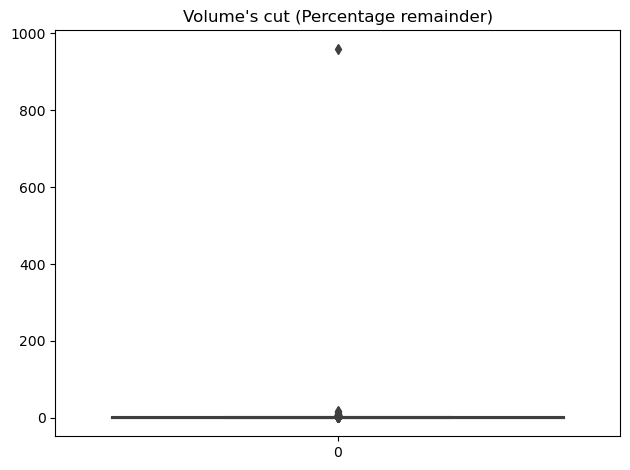

count    996.000000
mean       1.984653
std       30.411910
min        0.000000
25%        0.382212
50%        0.819037
75%        1.228270
max      960.000000
Name: Volume's cut (Percentage remainder), dtype: float64


In [25]:
#Now let's explore the variable "Volume's cut (Percentage remainder)"

sns.boxplot(demand_variation["Volume's cut (Percentage remainder)"])
plt.title(label="Volume's cut (Percentage remainder)", fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation["Volume's cut (Percentage remainder)"].describe())

In [26]:
#There is a very strange value out of the valid scope for such a variable (decimal values)
#Let's repeat the same approach on finding the position of the extreme value we have applied above, 
#removing this extreme value from the data set

max_index = demand_variation["Volume's cut (Percentage remainder)"].idxmax()
print('Index of maximal value: ',max_index)

Index of maximal value:  1078


In [27]:
#Let's then now remove it from the data set
demand_variation = demand_variation.drop(max_index)

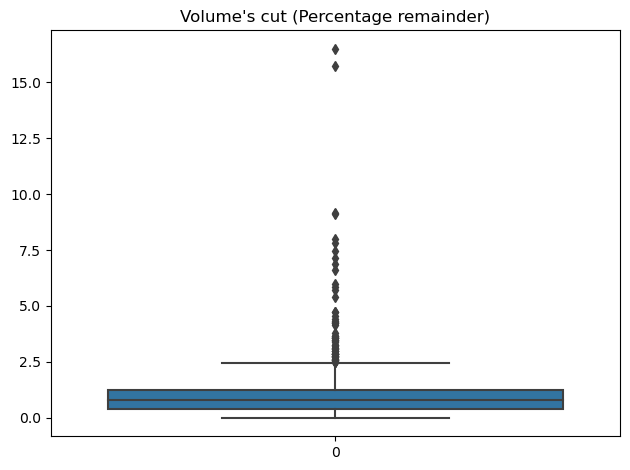

count    995.000000
mean       1.021823
std        1.246346
min        0.000000
25%        0.379808
50%        0.818182
75%        1.225750
max       16.494024
Name: Volume's cut (Percentage remainder), dtype: float64


In [28]:
#Let's check if the changes have worked

sns.boxplot(demand_variation["Volume's cut (Percentage remainder)"])
plt.title(label="Volume's cut (Percentage remainder)", fontsize=12)
plt.tight_layout()
plt.show()

print(demand_variation["Volume's cut (Percentage remainder)"].describe())

In [29]:
#To finish the EDA step and now that we have already interpreted all the critical aspects of the data set, 
#let's rename the columns to make it shorter and more practical for coming data handling tasks
demand_variation.columns

Index(['Part number', 'Type', 'Client', 'First Preview Week',
       'Production Week (W0)', 'Month', 'Holliday', 'Module cost',
       'Registered Vehicles Variation (M-1)', 'Interest rate (M-1)',
       'Inflation (M-1)', 'Initial previewed volume', 'Confirmed volume',
       'Leadtime preview', 'Volume's cut (Percentage remainder)'],
      dtype='object')

In [30]:
demand_variation.columns = ['PN', 'Type', 'Client', 'PreviewWeek',
       'ProductionWeek', 'Month', 'holiday', 'PNCost',
       'RegisteredVehicles(M-1)', 'InterestRate(M-1)',
       'Inflation(M-1)', 'PreviewedVolume', 'ConfirmedVolume',
       'LeadtimePreview', 'Cut(Remainder)']

In [31]:
#Checking if the changes are well succeed
demand_variation

,PN,Type,Client,PreviewWeek,ProductionWeek,Month,holiday,PNCost,RegisteredVehicles(M-1),InterestRate(M-1),Inflation(M-1),PreviewedVolume,ConfirmedVolume,LeadtimePreview,Cut(Remainder)
0,C,A,A,12,27,7,False,17.25,124806,4.50,1.3,4770,1620,15,0.339623
1,C,A,A,12,28,7,False,17.25,124806,4.50,1.3,4770,2070,16,0.433962
2,C,A,A,12,29,7,False,17.25,124806,4.50,1.3,4860,2880,17,0.592593
3,C,A,A,12,30,7,False,17.25,124806,4.50,1.3,4770,2700,18,0.566038
4,C,A,A,12,31,7,False,17.25,124806,4.50,1.3,3960,2790,19,0.704545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,I,B,E,6,22,5,False,20.26,139390,2.65,1.6,1376,800,16,0.581395
1088,I,B,E,6,23,5,True,20.26,139390,2.40,1.6,1376,1280,17,0.930233
1089,I,B,E,6,24,6,False,20.26,132191,2.40,1.7,1376,1760,18,1.279070
1090,I,B,E,6,25,6,False,20.26,132191,2.40,1.7,1376,560,19,0.406977


## 3. Features extraction and engineering (already partially performed)

In [32]:
#We first need to import some necessaries libraries for the feature engineering tasks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [33]:
#Let's then begin by changing the values of the holiday Column to 0's and 1's
demand_variation['holiday'] = demand_variation['holiday'].map({True:1, False:0})
demand_variation['holiday'].head()

0    0
1    0
2    0
3    0
4    0
Name: holiday, dtype: int64

In [34]:
#Confirming if all the observations remain unchanged
demand_variation['holiday'].shape

(995,)

In [35]:
# Finding the other categorical columns 
cat_cols = demand_variation.select_dtypes(include='object')
print(cat_cols.head())
print("-"*20)
print(cat_cols.columns)
print("-"*20)
print(cat_cols.shape)

  PN Type Client
0  C    A      A
1  C    A      A
2  C    A      A
3  C    A      A
4  C    A      A
--------------------
Index(['PN', 'Type', 'Client'], dtype='object')
--------------------
(995, 3)


In [36]:
cat_cols_list = list(cat_cols.columns)
cat_cols_list

['PN', 'Type', 'Client']

In [37]:
# Instantiate the ColumnTransformer 
ct = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), cat_cols.columns)],
    remainder='passthrough'  
)  # Keep other columns (like 'Price')

# Fit and transform
transformed_array = ct.fit_transform(demand_variation)

# Get feature names
encoded_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(cat_cols.columns)

# Combine with passthrough column names
all_feature_names = list(encoded_feature_names) + [col for col in demand_variation.columns if col not in cat_cols]

# Create final DataFrame
final_df = pd.DataFrame(transformed_array, columns=all_feature_names, index=demand_variation.index)
final_df

,PN_A,PN_B,PN_C,PN_D,PN_E,PN_F,PN_G,PN_H,PN_I,PN_J,...,Month,holiday,PNCost,RegisteredVehicles(M-1),InterestRate(M-1),Inflation(M-1),PreviewedVolume,ConfirmedVolume,LeadtimePreview,Cut(Remainder)
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,1620.0,15.0,0.339623
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,2070.0,16.0,0.433962
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4860.0,2880.0,17.0,0.592593
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,2700.0,18.0,0.566038
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,3960.0,2790.0,19.0,0.704545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,0.0,20.26,139390.0,2.65,1.6,1376.0,800.0,16.0,0.581395
1088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,1.0,20.26,139390.0,2.40,1.6,1376.0,1280.0,17.0,0.930233
1089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,0.0,20.26,132191.0,2.40,1.7,1376.0,1760.0,18.0,1.279070
1090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,0.0,20.26,132191.0,2.40,1.7,1376.0,560.0,19.0,0.406977


In [38]:
#Now that we are ready with the one hot encoding for the categorical columns, we will switch focus to the numerical ones
numeric_cols = demand_variation.select_dtypes(include='number')
numeric_cols = list(numeric_cols.columns)
numeric_cols

['PreviewWeek',
 'ProductionWeek',
 'Month',
 'holiday',
 'PNCost',
 'RegisteredVehicles(M-1)',
 'InterestRate(M-1)',
 'Inflation(M-1)',
 'PreviewedVolume',
 'ConfirmedVolume',
 'LeadtimePreview',
 'Cut(Remainder)']

In [39]:
#Checking if the newly created data set just with numerical columns is correct
print(demand_variation[numeric_cols].head())
print(demand_variation[numeric_cols].shape)

   PreviewWeek  ProductionWeek  Month  holiday  PNCost  \
0           12              27      7        0   17.25   
1           12              28      7        0   17.25   
2           12              29      7        0   17.25   
3           12              30      7        0   17.25   
4           12              31      7        0   17.25   

   RegisteredVehicles(M-1)  InterestRate(M-1)  Inflation(M-1)  \
0                   124806                4.5             1.3   
1                   124806                4.5             1.3   
2                   124806                4.5             1.3   
3                   124806                4.5             1.3   
4                   124806                4.5             1.3   

   PreviewedVolume  ConfirmedVolume  LeadtimePreview  Cut(Remainder)  
0             4770             1620               15        0.339623  
1             4770             2070               16        0.433962  
2             4860             2880            

In [40]:
#As we are not working with linear regression models but with tree based regressors, it's not recommended that we transform or scale 
#also the numerical columns, therefore we will not change their structure

#Let's now copy the current one and create a final data frame for the purpose of having a safe back-up and being able to start with the training of data
final_demand_variation = final_df
final_demand_variation.shape

(995, 41)

In [41]:
final_demand_variation

,PN_A,PN_B,PN_C,PN_D,PN_E,PN_F,PN_G,PN_H,PN_I,PN_J,...,Month,holiday,PNCost,RegisteredVehicles(M-1),InterestRate(M-1),Inflation(M-1),PreviewedVolume,ConfirmedVolume,LeadtimePreview,Cut(Remainder)
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,1620.0,15.0,0.339623
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,2070.0,16.0,0.433962
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4860.0,2880.0,17.0,0.592593
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,4770.0,2700.0,18.0,0.566038
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,17.25,124806.0,4.50,1.3,3960.0,2790.0,19.0,0.704545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,0.0,20.26,139390.0,2.65,1.6,1376.0,800.0,16.0,0.581395
1088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,1.0,20.26,139390.0,2.40,1.6,1376.0,1280.0,17.0,0.930233
1089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,0.0,20.26,132191.0,2.40,1.7,1376.0,1760.0,18.0,1.279070
1090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,0.0,20.26,132191.0,2.40,1.7,1376.0,560.0,19.0,0.406977


In [42]:
#Checking if the there is any missing values
final_demand_variation.isna().sum()

PN_A                       0
PN_B                       0
PN_C                       0
PN_D                       0
PN_E                       0
PN_F                       0
PN_G                       0
PN_H                       0
PN_I                       0
PN_J                       0
PN_K                       0
PN_L                       0
PN_M                       0
PN_N                       0
PN_O                       0
PN_P                       0
PN_Q                       0
PN_R                       0
PN_S                       0
PN_T                       0
PN_U                       0
Type_A                     0
Type_B                     0
Type_C                     0
Client_A                   0
Client_B                   0
Client_C                   0
Client_D                   0
Client_E                   0
PreviewWeek                0
ProductionWeek             0
Month                      0
holiday                    0
PNCost                     0
RegisteredVehi

In [43]:
#Final check
mask = final_demand_variation.isna().any(axis=1)
filtered_df = final_demand_variation[mask]
filtered_df

,PN_A,PN_B,PN_C,PN_D,PN_E,PN_F,PN_G,PN_H,PN_I,PN_J,...,Month,holiday,PNCost,RegisteredVehicles(M-1),InterestRate(M-1),Inflation(M-1),PreviewedVolume,ConfirmedVolume,LeadtimePreview,Cut(Remainder)


## 4. Split the dataset into training and test sets

In [44]:
#We first need to import some necessaries libraries for the data set splitting tasks
from sklearn.model_selection import train_test_split

In [45]:
# Separate features and target
X = final_demand_variation.drop('Cut(Remainder)', axis=1)
y = final_demand_variation['Cut(Remainder)']

In [46]:
#Applying the train test split
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
#Checking if the split was correctly applied
print('X-Train Test: ',X_train_test.shape)
print('Y-Train Test: ',y_train_test.shape)
print('X-Validation: ',X_val.shape)
print('Y-Validation: ',y_val.shape)

X-Train Test:  (796, 40)
Y-Train Test:  (796,)
X-Validation:  (199, 40)
Y-Validation:  (199,)


## 5. Create model instance and define its hyperparameters

In [48]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [49]:
#We first need to import some necessaries libraries for the data set training tasks
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , make_scorer
from sklearn.model_selection import GridSearchCV, KFold

In [50]:
#Let's instantiate the XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

In [51]:
#...the cross validation object...
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [52]:
#...and the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

## 6. Define cross-validation strategy

In [53]:
#Now we are ready to put all together and instantiate Grid Search object
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=cv,
    verbose=1,
    n_jobs=-1
)

## 7. Train the model and evaluate the cross-validation results

In [54]:
import time

#Now we'll fit the Grid Search in the train_test sets, looking for the best hyper parameter's set and its respective metrics
start_time = time.time()
model = grid_search.fit(X_train_test, y_train_test)
end_time = time.time()

# Report duration
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/home/79269d14-e0e1-4694-9733-e8de9ef44478/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/79269d14-e0e1-4694-9733-e8de9ef44478/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/79269d14-e0e1-4694-9733-e8de9ef44478/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/79269d14-e0e1-4694-9733-e8de9ef44478/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Training completed in 54.64 seconds.


In [55]:
#Now let's check what are the optimal hyper parameters...
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Negative MSE):", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV Score (Negative MSE): -0.08511068784094047


In [56]:
#and finally train the model with the best hyper parameters in the training set
start_time = time.time()
best_model = grid_search.best_estimator_
end_time = time.time()

# Report duration
elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

Training completed in 0.00 seconds.


## 8. Perform metrics evaluation

In [57]:
# First we evaluate the model's metrics achieved in the train and test set
y_pred_test = best_model.predict(X_train_test)
mse_test = mean_squared_error(y_train_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_train_test, y_pred_test)
r2_test = r2_score(y_train_test, y_pred_test)

#Now let's calculate the Adjusted R2 score, which is not given by default when using Scikit Learn
n = len(y_train_test)
p = X_train_test.shape[1]
adj_r2_test = 1 - ((1 - r2_test) * (n - 1)) / (n - p - 1)

print("Test Set MSE:", mse_test)
print("Test Set RMSE:", rmse_test)
print("Test Set MAE:", mae_test)
print("Test Set R2 Score:", r2_test)
print("Test Set Ajusted R2 Score:", adj_r2_test)

Test Set MSE: 0.0019470442241746524
Test Set RMSE: 0.0441253240687777
Test Set MAE: 0.0319576787024017
Test Set R2 Score: 0.9988290909986383
Test Set Ajusted R2 Score: 0.9987670560846589


## 9. Feature importance analysis

In [58]:
#Let's now perform some evaluation regarding the explanatory importance of each feature in the model
#For that, first we need to import the necessary library
from xgboost import plot_importance

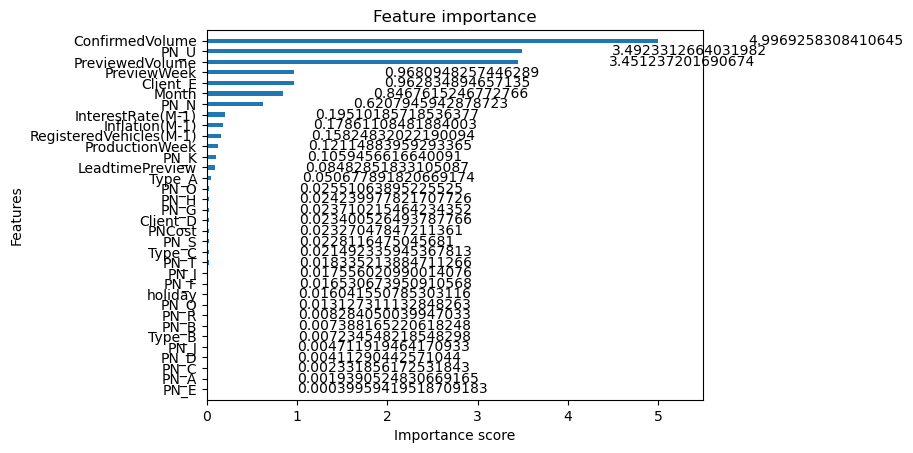

In [76]:
#We will perform feature importance according to two different criterias: the first is 'gain'...
plot_importance(best_model, grid=False, height=0.4, importance_type='gain');


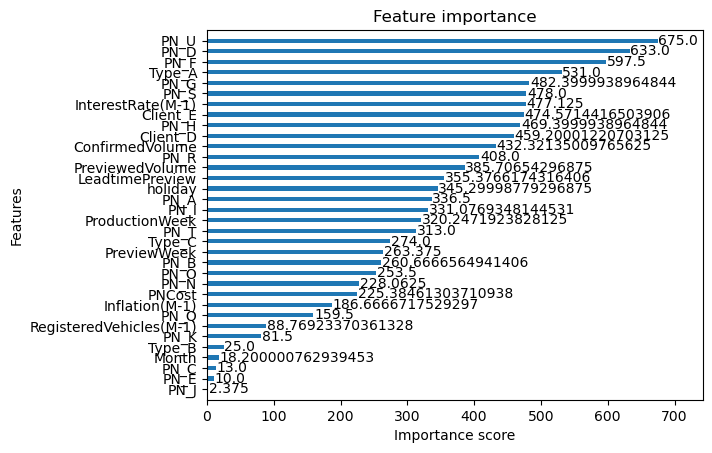

In [77]:
#... and the second 'cover'
plot_importance(best_model, grid=False, height=0.4, importance_type='cover') ;

In [78]:
# Extract feature importance scores
importance_types = ['weight', 'gain', 'cover']
importance_dicts = {
    imp_type: best_model.get_booster().get_score(importance_type=imp_type)
    for imp_type in importance_types
}

# Convert to DataFrame
importance_df = pd.DataFrame(importance_dicts).fillna(0)

# Rename index to 'feature'
importance_df.index.name = 'feature'
importance_df.reset_index(inplace=True)

#Show the first rows for quick checking
importance_df.head()


,feature,weight,gain,cover
0,PN_A,2.0,0.001939,336.500000
1,PN_B,3.0,0.007388,260.666656
2,PN_C,1.0,0.002332,13.000000
3,PN_D,2.0,0.004113,633.000000
4,PN_E,1.0,0.000400,10.000000


In [79]:
#The indexes themselves give us some impressions about which are the most important features in the model
#But are difficult to have a quantitative threshold or reference to understand if some of them could be removed from the model
#without impacts in the model predictive power, therefore let's try to calculate some relative metrics
importance_df['relative_gain'] = importance_df['gain'] / importance_df['gain'].sum()
importance_df['relative_weight'] = importance_df['weight'] / importance_df['weight'].sum()
importance_df['relative_cover'] = importance_df['cover'] / importance_df['cover'].sum()

#Calculate general influence as the sum of the three relative metrics
importance_df['general_influence'] = (
    (importance_df['relative_gain'] +
    importance_df['relative_weight'] +
    importance_df['relative_cover']) / 3 * 100
)

#Sort by one of the metrics
importance_df = importance_df.sort_values(by='general_influence', ascending=False)
importance_df

,feature,weight,gain,cover,relative_gain,relative_weight,relative_cover,general_influence
32,ConfirmedVolume,445.0,4.996926,432.321350,0.302551,0.347385,0.040805,23.024711
31,PreviewedVolume,351.0,3.451237,385.706543,0.208964,0.274005,0.036406,17.312461
17,PN_U,5.0,3.492331,675.000000,0.211452,0.003903,0.063711,9.302197
23,PreviewWeek,96.0,0.968095,263.375000,0.058616,0.074941,0.024859,5.280540
22,Client_E,28.0,0.962835,474.571442,0.058297,0.021858,0.044793,4.164944
24,ProductionWeek,89.0,0.121149,320.247192,0.007335,0.069477,0.030227,3.567976
33,LeadtimePreview,77.0,0.084829,355.376617,0.005136,0.060109,0.033543,3.292941
11,PN_N,16.0,0.620795,228.062500,0.037588,0.012490,0.021526,2.386794
29,InterestRate(M-1),16.0,0.195102,477.125000,0.011813,0.012490,0.045034,2.311246
3,PN_D,2.0,0.004113,633.000000,0.000249,0.001561,0.059747,2.051901


In [80]:
#Checking if the sum of 'general_influence' adds up to 100%
importance_df['general_influence'].sum()

100.0

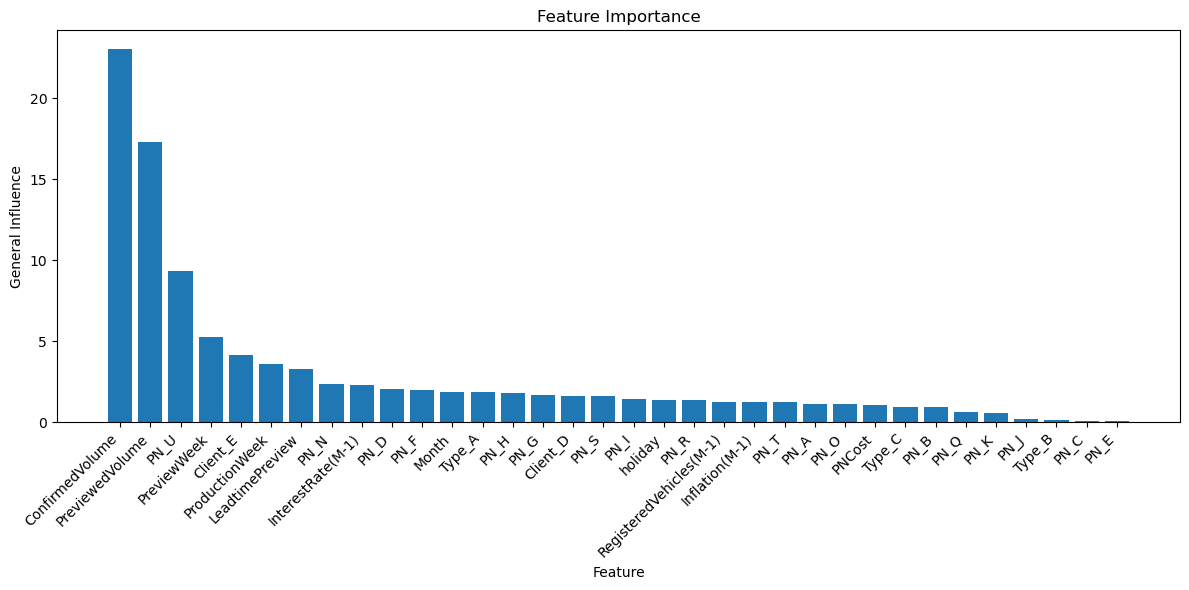

In [81]:
#Plotting 'general_influence' to enhance our understanding on that
plt.figure(figsize=(12, 6))
plt.bar(x=importance_df['feature'], height=importance_df['general_influence'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('General Influence')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

The independent variables that presented the lower importance ratios in the models belong **with another one-hot encoded ones that have presented high importance and influences values**, therefore we decide not to remove them from the model, they are: **PN (Part Number) and Client**.

Beyond that, some of the input variables which are independent in terms of not being one-hot encoded sums themselves a total of **almost 5% of general influence** in the models prediction power. From our point of view this percentage is significant and therefore we decided not to remove them from the model as well, they are: **Interes Rate, Registered Vehicles, Month and Inflation**.

## 10. Train the model again in the train and test sets and test on the validation set

In [65]:
#Let's instantiate the final XGBoost model and set it with the optimal hyper parameters
xgb_reg_final = XGBRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, subsample=0.8, colsample_bytree=1.0, objective='reg:squarederror', random_state=42)

In [66]:
#Fitting the model with the complete train_test set
final_model = xgb_reg_final.fit(X_train_test, y_train_test)

In [67]:
#Now that we are satisfied with the performance of the model's hyper parameters, let's evaluate it once again
#with the validation set
y_pred_val = final_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

#Now let's calculate the Adjusted R2 score, which is not given by default when using Scikit Learn
n = len(y_val)
p = X_val.shape[1]
adj_r2_val = 1 - ((1 - r2_val) * (n - 1)) / (n - p - 1)

print("Validation Set MSE:", mse_val)
print("Validation Set RMSE:", rmse_val)
print("Validation Set MAE:", mae_val)
print("Validation Set R2 Score:", r2_val)
print("Validation Set Ajusted R2 Score:", adj_r2_val)

Validation Set MSE: 0.04738020559893373
Validation Set RMSE: 0.21766994647615856
Validation Set MAE: 0.07958268705158626
Validation Set R2 Score: 0.9568869962083095
Validation Set Ajusted R2 Score: 0.9459723117040841


In [68]:
#Finally, let's create a data frame to ease out metrics comparison and intepretation
metrics = ['MSE', 'RMSE', 'MAE', 'R^2', 'Adjusted R^2']
metrics_val = [mse_val, rmse_val, mae_val, r2_val, adj_r2_val]
metrics_test = [mse_test, rmse_test, mae_test, r2_test, adj_r2_test]

final_metrics = pd.DataFrame(metrics_test, index=metrics, columns=['Test'], dtype='float')
final_metrics['Validation'] = metrics_val
final_metrics

,Test,Validation
MSE,0.001947,0.047380
RMSE,0.044125,0.217670
MAE,0.031958,0.079583
R^2,0.998829,0.956887
Adjusted R^2,0.998767,0.945972


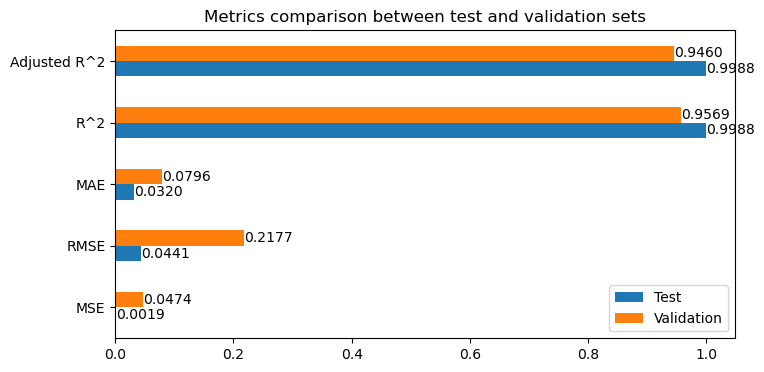

In [69]:
#Plotting it to give us some visual insights
ax = final_metrics.plot(kind='barh', title='Metrics comparison between test and validation sets', figsize=(8, 4));

# Add labels to each BarContainer
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

## 11. Save the model

In [70]:
# Save the model to a file
import pickle

with open('xgbr_gs_model.pkl', 'wb') as file:
    pickle.dump(model, file)


## 12. Final Considerations

We have now reached the conclusion of our pilot modeling phase for the **volume cut prediction** using an XGBoost regressor. Upon reviewing the regression metrics available, we observe that the model's performance is highly satisfactory.

The strategy of reserving a portion of the dataset as a **validation set** — to evaluate the model on previously unseen data — has proven to be a robust and reliable approach for estimating real-world performance with greater confidence. This methodology is widely adopted by data scientists to ensure a reasonable level of trust in the model before advancing to deployment and production stages.

The model performed very well on the validation set, albeit slightly worse than on the train-test set, which was expected. The **R² score of 0.9569** and the **Adjusted R² of 0.9460** are both strong indicators of predictive accuracy. Additionally, the error metrics fall within acceptable ranges, reinforcing the model’s reliability. While the metrics on the train-test set are notably high — as anticipated — they should not be considered definitive indicators of success, but rather complementary to the validation results. It is known that the model lacks more data to really be able to prove it's predictive power, what's unfortunately not available currently.